# FINAL PROJECT

Name: Xulai Wu <br>
Github Username: LukeWu5121 <br>
USC ID: 6591102106

In [52]:
import os
import shutil
import re
import matplotlib.pyplot as plt
import numpy as np

from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications import ResNet50, ResNet101, EfficientNetB0, VGG16
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score, roc_auc_score

## b

In [ ]:
data_path = "RealWaste"
train_path = "Processed/train"
test_path = "Processed/test"


os.makedirs(train_path, exist_ok=True)
os.makedirs(test_path, exist_ok=True)

def extract_number(filename):
    match = re.search(r'\d+', filename)
    return int(match.group()) if match else -1


for category in sorted(os.listdir(data_path)):
    category_path = os.path.join(data_path, category)
    if os.path.isdir(category_path):
        images = sorted(os.listdir(category_path), key=extract_number)
        total_images = len(images)
        split_index = int(0.8 * total_images)
        train_images = images[:split_index]
        test_images = images[split_index:]

        os.makedirs(os.path.join(train_path, category), exist_ok=True)
        os.makedirs(os.path.join(test_path, category), exist_ok=True)

        for img in train_images:
            src = os.path.join(category_path, img)
            dst = os.path.join(train_path, category, img)
            shutil.copyfile(src, dst)

        for img in test_images:
            src = os.path.join(category_path, img)
            dst = os.path.join(test_path, category, img)
            shutil.copyfile(src, dst)


✔ 数据按编号顺序正确划分完成。


## C

In [ ]:
def build_transfer_model(base_model_fn, input_shape=(224, 224, 3), num_classes=9):
    base_model = base_model_fn(
        weights='imagenet',
        include_top=False,
        input_shape=input_shape
    )
    for layer in base_model.layers:
        layer.trainable = False

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(x)
    x = Dropout(0.2)(x)
    output = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=output)
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

resnet50_model = build_transfer_model(ResNet50, num_classes=train_generator.num_classes)
resnet101_model = build_transfer_model(ResNet101, num_classes=train_generator.num_classes)
EfficientNetB0 = build_transfer_model(EfficientNetB0, num_classes=train_generator.num_classes)
vgg16_model = build_transfer_model(VGG16, num_classes=train_generator.num_classes)



def train_model(model, name):
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ]

    history = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=50,
        callbacks=callbacks
    )

    plt.figure(figsize=(12, 4))
    plt.suptitle(name)
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.legend(), plt.title('Loss')
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.legend(), plt.title('Accuracy')
    plt.show()
    return history


In [55]:
img_size = (224, 224)
batch_size = 5

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    validation_split=0.2
)

train_generator = train_datagen.flow_from_directory(
    "Processed/train",
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_generator = train_datagen.flow_from_directory(
    "Processed/train",
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=True
)


Found 3042 images belonging to 9 classes.
Found 756 images belonging to 9 classes.


Epoch 1/50


C:\Users\wuxul\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


609/609 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - accuracy: 0.2738 - loss: 2.7785

609/609 ━━━━━━━━━━━━━━━━━━━━ 127s 196ms/step - accuracy: 0.2739 - loss: 2.7780 - val_accuracy: 0.3466 - val_loss: 2.1314
Epoch 2/50
609/609 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - accuracy: 0.3516 - loss: 2.0609

609/609 ━━━━━━━━━━━━━━━━━━━━ 117s 192ms/step - accuracy: 0.3516 - loss: 2.0608 - val_accuracy: 0.3638 - val_loss: 1.9607
Epoch 3/50
609/609 ━━━━━━━━━━━━━━━━━━━━ 128s 210ms/step - accuracy: 0.3639 - loss: 1.9483 - val_accuracy: 0.3730 - val_loss: 2.0603
Epoch 4/50
609/609 ━━━━━━━━━━━━━━━━━━━━ 124s 203ms/step - accuracy: 0.3644 - loss: 1.8971 - val_accuracy: 0.3466 - val_loss: 1.9913
Epoch 5/50
609/609 ━━━━━━━━━━━━━━━━━━━━ 124s 203ms/step - accuracy: 0.3752 - loss: 1.8641 - val_accuracy: 0.3479 - val_loss: 1.9675
Epoch 6/50
609/609 ━━━━━━━━━━━━━━━━━━━━ 121s 199ms/step - accuracy: 0.3761 - loss: 1.8533 - val_accuracy: 0.3333 - val_loss: 1.9937
Epoch 7/50
609/609 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - accuracy: 0.3731 - loss: 1.8847

609/609 ━━━━━━━━━━━━━━━━━━━━ 117s 193ms/step - accuracy: 0.3731 - loss: 1.8847 - val_accuracy: 0.3704 - val_loss: 1.9081
Epoch 8/50
609/609 ━━━━━━━━━━━━━━━━━━━━ 116s 190ms/step - accuracy: 0.3821 - loss: 1.8534 - val_accuracy: 0.3677 - val_loss: 1.9203
Epoch 9/50
609/609 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - accuracy: 0.3766 - loss: 1.8457

609/609 ━━━━━━━━━━━━━━━━━━━━ 116s 191ms/step - accuracy: 0.3766 - loss: 1.8457 - val_accuracy: 0.3876 - val_loss: 1.8833
Epoch 10/50
609/609 ━━━━━━━━━━━━━━━━━━━━ 116s 191ms/step - accuracy: 0.3912 - loss: 1.8158 - val_accuracy: 0.3704 - val_loss: 1.9407
Epoch 11/50
609/609 ━━━━━━━━━━━━━━━━━━━━ 126s 206ms/step - accuracy: 0.3926 - loss: 1.8242 - val_accuracy: 0.3823 - val_loss: 1.9302
Epoch 12/50
609/609 ━━━━━━━━━━━━━━━━━━━━ 110s 181ms/step - accuracy: 0.3998 - loss: 1.8214 - val_accuracy: 0.3426 - val_loss: 1.9703
Epoch 13/50
609/609 ━━━━━━━━━━━━━━━━━━━━ 115s 189ms/step - accuracy: 0.3902 - loss: 1.8040 - val_accuracy: 0.3320 - val_loss: 1.9220
Epoch 14/50
609/609 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - accuracy: 0.4031 - loss: 1.7881

609/609 ━━━━━━━━━━━━━━━━━━━━ 116s 191ms/step - accuracy: 0.4031 - loss: 1.7881 - val_accuracy: 0.3968 - val_loss: 1.8518
Epoch 15/50
609/609 ━━━━━━━━━━━━━━━━━━━━ 114s 187ms/step - accuracy: 0.4165 - loss: 1.7945 - val_accuracy: 0.3664 - val_loss: 1.8924
Epoch 16/50
609/609 ━━━━━━━━━━━━━━━━━━━━ 112s 183ms/step - accuracy: 0.4214 - loss: 1.7511 - val_accuracy: 0.3664 - val_loss: 1.9101
Epoch 17/50
609/609 ━━━━━━━━━━━━━━━━━━━━ 119s 195ms/step - accuracy: 0.3976 - loss: 1.7623 - val_accuracy: 0.3638 - val_loss: 1.9231
Epoch 18/50
609/609 ━━━━━━━━━━━━━━━━━━━━ 114s 187ms/step - accuracy: 0.3880 - loss: 1.8080 - val_accuracy: 0.3598 - val_loss: 1.8894
Epoch 19/50
609/609 ━━━━━━━━━━━━━━━━━━━━ 113s 186ms/step - accuracy: 0.4083 - loss: 1.7538 - val_accuracy: 0.3704 - val_loss: 1.9247


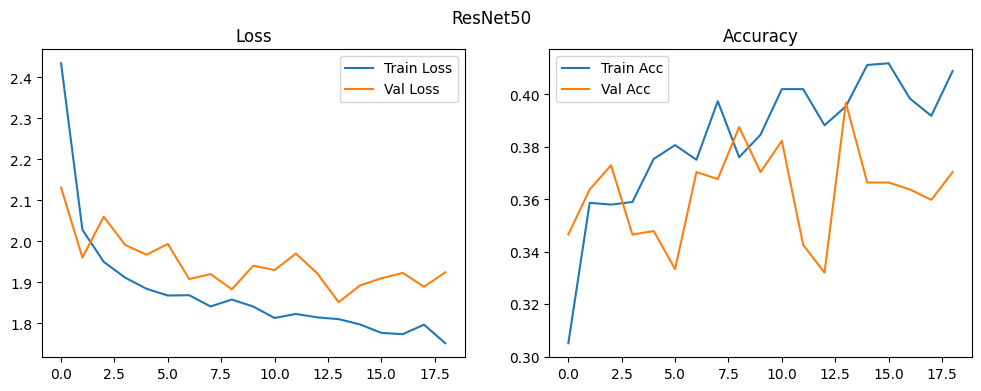

Epoch 1/50
609/609 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step - accuracy: 0.2869 - loss: 2.6861

609/609 ━━━━━━━━━━━━━━━━━━━━ 207s 325ms/step - accuracy: 0.2870 - loss: 2.6855 - val_accuracy: 0.3426 - val_loss: 2.1540
Epoch 2/50
609/609 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step - accuracy: 0.3462 - loss: 2.0429

609/609 ━━━━━━━━━━━━━━━━━━━━ 185s 304ms/step - accuracy: 0.3462 - loss: 2.0428 - val_accuracy: 0.3611 - val_loss: 2.0301
Epoch 3/50
609/609 ━━━━━━━━━━━━━━━━━━━━ 196s 322ms/step - accuracy: 0.3582 - loss: 1.9406 - val_accuracy: 0.3624 - val_loss: 2.0458
Epoch 4/50
609/609 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step - accuracy: 0.3735 - loss: 1.9218

609/609 ━━━━━━━━━━━━━━━━━━━━ 195s 320ms/step - accuracy: 0.3734 - loss: 1.9218 - val_accuracy: 0.3690 - val_loss: 1.9554
Epoch 5/50
609/609 ━━━━━━━━━━━━━━━━━━━━ 197s 324ms/step - accuracy: 0.3597 - loss: 1.9133 - val_accuracy: 0.3360 - val_loss: 2.0145
Epoch 6/50
609/609 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step - accuracy: 0.3611 - loss: 1.8895

609/609 ━━━━━━━━━━━━━━━━━━━━ 184s 302ms/step - accuracy: 0.3611 - loss: 1.8895 - val_accuracy: 0.3704 - val_loss: 1.9551
Epoch 7/50
609/609 ━━━━━━━━━━━━━━━━━━━━ 206s 338ms/step - accuracy: 0.3574 - loss: 1.8945 - val_accuracy: 0.3532 - val_loss: 2.0267
Epoch 8/50
609/609 ━━━━━━━━━━━━━━━━━━━━ 201s 330ms/step - accuracy: 0.3617 - loss: 1.8763 - val_accuracy: 0.3545 - val_loss: 1.9784
Epoch 9/50
609/609 ━━━━━━━━━━━━━━━━━━━━ 203s 334ms/step - accuracy: 0.3769 - loss: 1.8607 - val_accuracy: 0.3399 - val_loss: 1.9893
Epoch 10/50
609/609 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step - accuracy: 0.3774 - loss: 1.8467

609/609 ━━━━━━━━━━━━━━━━━━━━ 209s 342ms/step - accuracy: 0.3774 - loss: 1.8468 - val_accuracy: 0.3519 - val_loss: 1.9096
Epoch 11/50
609/609 ━━━━━━━━━━━━━━━━━━━━ 189s 311ms/step - accuracy: 0.3647 - loss: 1.8630 - val_accuracy: 0.3677 - val_loss: 1.9502
Epoch 12/50
609/609 ━━━━━━━━━━━━━━━━━━━━ 178s 292ms/step - accuracy: 0.3763 - loss: 1.8522 - val_accuracy: 0.3585 - val_loss: 1.9525
Epoch 13/50
609/609 ━━━━━━━━━━━━━━━━━━━━ 177s 291ms/step - accuracy: 0.3841 - loss: 1.8517 - val_accuracy: 0.3796 - val_loss: 1.9208
Epoch 14/50
609/609 ━━━━━━━━━━━━━━━━━━━━ 178s 292ms/step - accuracy: 0.3785 - loss: 1.8292 - val_accuracy: 0.3545 - val_loss: 1.9462
Epoch 15/50
609/609 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step - accuracy: 0.3911 - loss: 1.8058

609/609 ━━━━━━━━━━━━━━━━━━━━ 180s 295ms/step - accuracy: 0.3911 - loss: 1.8059 - val_accuracy: 0.3532 - val_loss: 1.9075
Epoch 16/50
609/609 ━━━━━━━━━━━━━━━━━━━━ 178s 293ms/step - accuracy: 0.3805 - loss: 1.8299 - val_accuracy: 0.3571 - val_loss: 1.9826
Epoch 17/50
609/609 ━━━━━━━━━━━━━━━━━━━━ 178s 292ms/step - accuracy: 0.3793 - loss: 1.8335 - val_accuracy: 0.3585 - val_loss: 1.9236
Epoch 18/50
609/609 ━━━━━━━━━━━━━━━━━━━━ 177s 291ms/step - accuracy: 0.3711 - loss: 1.8205 - val_accuracy: 0.3730 - val_loss: 1.9450
Epoch 19/50
609/609 ━━━━━━━━━━━━━━━━━━━━ 177s 291ms/step - accuracy: 0.3660 - loss: 1.8478 - val_accuracy: 0.3492 - val_loss: 1.9300
Epoch 20/50
609/609 ━━━━━━━━━━━━━━━━━━━━ 178s 292ms/step - accuracy: 0.3729 - loss: 1.8225 - val_accuracy: 0.3677 - val_loss: 1.9452


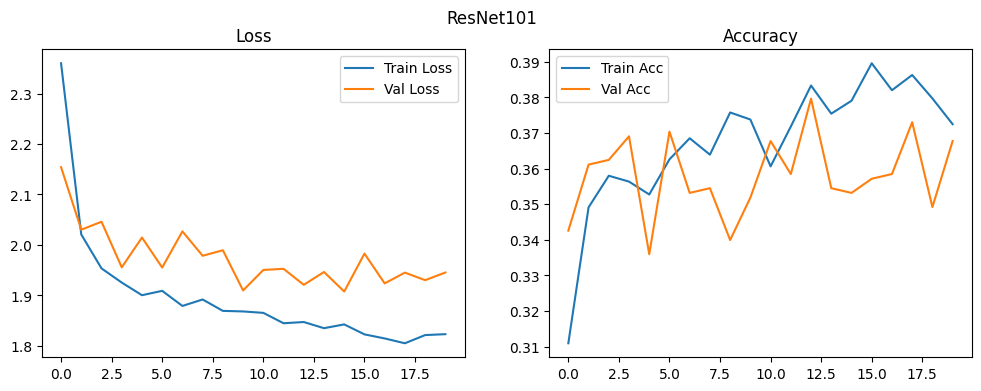

Epoch 1/50
609/609 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.1396 - loss: 4.2690

609/609 ━━━━━━━━━━━━━━━━━━━━ 71s 102ms/step - accuracy: 0.1396 - loss: 4.2681 - val_accuracy: 0.1667 - val_loss: 2.6906
Epoch 2/50
609/609 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.1398 - loss: 2.7194

609/609 ━━━━━━━━━━━━━━━━━━━━ 60s 99ms/step - accuracy: 0.1398 - loss: 2.7192 - val_accuracy: 0.1944 - val_loss: 2.3140
Epoch 3/50
609/609 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.1627 - loss: 2.3310

609/609 ━━━━━━━━━━━━━━━━━━━━ 60s 99ms/step - accuracy: 0.1627 - loss: 2.3309 - val_accuracy: 0.1667 - val_loss: 2.2182
Epoch 4/50
609/609 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.1756 - loss: 2.2458

609/609 ━━━━━━━━━━━━━━━━━━━━ 60s 98ms/step - accuracy: 0.1757 - loss: 2.2458 - val_accuracy: 0.1772 - val_loss: 2.1843
Epoch 5/50
609/609 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.1759 - loss: 2.2081

609/609 ━━━━━━━━━━━━━━━━━━━━ 60s 98ms/step - accuracy: 0.1759 - loss: 2.2081 - val_accuracy: 0.1944 - val_loss: 2.1607
Epoch 6/50
609/609 ━━━━━━━━━━━━━━━━━━━━ 60s 99ms/step - accuracy: 0.1919 - loss: 2.1831 - val_accuracy: 0.1944 - val_loss: 2.1664
Epoch 7/50
609/609 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.1987 - loss: 2.1577

609/609 ━━━━━━━━━━━━━━━━━━━━ 60s 99ms/step - accuracy: 0.1987 - loss: 2.1577 - val_accuracy: 0.1944 - val_loss: 2.1603
Epoch 8/50
609/609 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.2005 - loss: 2.1592

609/609 ━━━━━━━━━━━━━━━━━━━━ 60s 99ms/step - accuracy: 0.2005 - loss: 2.1592 - val_accuracy: 0.1944 - val_loss: 2.1555
Epoch 9/50
609/609 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.1922 - loss: 2.1615

609/609 ━━━━━━━━━━━━━━━━━━━━ 60s 98ms/step - accuracy: 0.1922 - loss: 2.1615 - val_accuracy: 0.1944 - val_loss: 2.1469
Epoch 10/50
609/609 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.1936 - loss: 2.1503

609/609 ━━━━━━━━━━━━━━━━━━━━ 60s 99ms/step - accuracy: 0.1936 - loss: 2.1503 - val_accuracy: 0.1944 - val_loss: 2.1439
Epoch 11/50
609/609 ━━━━━━━━━━━━━━━━━━━━ 60s 98ms/step - accuracy: 0.2045 - loss: 2.1359 - val_accuracy: 0.1944 - val_loss: 2.1474
Epoch 12/50
609/609 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.1954 - loss: 2.1485

609/609 ━━━━━━━━━━━━━━━━━━━━ 60s 99ms/step - accuracy: 0.1954 - loss: 2.1485 - val_accuracy: 0.1944 - val_loss: 2.1422
Epoch 13/50
609/609 ━━━━━━━━━━━━━━━━━━━━ 61s 100ms/step - accuracy: 0.1952 - loss: 2.1448 - val_accuracy: 0.1944 - val_loss: 2.1423
Epoch 14/50
609/609 ━━━━━━━━━━━━━━━━━━━━ 60s 99ms/step - accuracy: 0.1818 - loss: 2.1467 - val_accuracy: 0.1944 - val_loss: 2.1462
Epoch 15/50
609/609 ━━━━━━━━━━━━━━━━━━━━ 60s 98ms/step - accuracy: 0.1852 - loss: 2.1483 - val_accuracy: 0.1944 - val_loss: 2.1429
Epoch 16/50
609/609 ━━━━━━━━━━━━━━━━━━━━ 60s 98ms/step - accuracy: 0.1913 - loss: 2.1451 - val_accuracy: 0.1944 - val_loss: 2.1439
Epoch 17/50
609/609 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.2008 - loss: 2.1330

609/609 ━━━━━━━━━━━━━━━━━━━━ 60s 99ms/step - accuracy: 0.2008 - loss: 2.1330 - val_accuracy: 0.1944 - val_loss: 2.1402
Epoch 18/50
609/609 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.2025 - loss: 2.1365

609/609 ━━━━━━━━━━━━━━━━━━━━ 62s 101ms/step - accuracy: 0.2024 - loss: 2.1365 - val_accuracy: 0.1944 - val_loss: 2.1401
Epoch 19/50
609/609 ━━━━━━━━━━━━━━━━━━━━ 60s 98ms/step - accuracy: 0.1977 - loss: 2.1367 - val_accuracy: 0.1944 - val_loss: 2.1405
Epoch 20/50
609/609 ━━━━━━━━━━━━━━━━━━━━ 60s 98ms/step - accuracy: 0.1883 - loss: 2.1542 - val_accuracy: 0.1944 - val_loss: 2.1430
Epoch 21/50
609/609 ━━━━━━━━━━━━━━━━━━━━ 60s 98ms/step - accuracy: 0.1897 - loss: 2.1413 - val_accuracy: 0.1944 - val_loss: 2.1431
Epoch 22/50
609/609 ━━━━━━━━━━━━━━━━━━━━ 61s 99ms/step - accuracy: 0.1994 - loss: 2.1374 - val_accuracy: 0.1944 - val_loss: 2.1427
Epoch 23/50
609/609 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.1922 - loss: 2.1428

609/609 ━━━━━━━━━━━━━━━━━━━━ 60s 99ms/step - accuracy: 0.1922 - loss: 2.1429 - val_accuracy: 0.1944 - val_loss: 2.1389
Epoch 24/50
609/609 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.1912 - loss: 2.1530

609/609 ━━━━━━━━━━━━━━━━━━━━ 60s 98ms/step - accuracy: 0.1912 - loss: 2.1530 - val_accuracy: 0.1944 - val_loss: 2.1374
Epoch 25/50
609/609 ━━━━━━━━━━━━━━━━━━━━ 60s 98ms/step - accuracy: 0.1949 - loss: 2.1315 - val_accuracy: 0.1944 - val_loss: 2.1390
Epoch 26/50
609/609 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.1935 - loss: 2.1409

609/609 ━━━━━━━━━━━━━━━━━━━━ 60s 98ms/step - accuracy: 0.1935 - loss: 2.1409 - val_accuracy: 0.1944 - val_loss: 2.1364
Epoch 27/50
609/609 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.2046 - loss: 2.1391

609/609 ━━━━━━━━━━━━━━━━━━━━ 60s 98ms/step - accuracy: 0.2046 - loss: 2.1391 - val_accuracy: 0.1944 - val_loss: 2.1363
Epoch 28/50
609/609 ━━━━━━━━━━━━━━━━━━━━ 60s 99ms/step - accuracy: 0.1914 - loss: 2.1478 - val_accuracy: 0.1944 - val_loss: 2.1368
Epoch 29/50
609/609 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.2010 - loss: 2.1375

609/609 ━━━━━━━━━━━━━━━━━━━━ 60s 99ms/step - accuracy: 0.2010 - loss: 2.1375 - val_accuracy: 0.1944 - val_loss: 2.1345
Epoch 30/50
609/609 ━━━━━━━━━━━━━━━━━━━━ 60s 98ms/step - accuracy: 0.2021 - loss: 2.1318 - val_accuracy: 0.1944 - val_loss: 2.1359
Epoch 31/50
609/609 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.1819 - loss: 2.1502

609/609 ━━━━━━━━━━━━━━━━━━━━ 60s 98ms/step - accuracy: 0.1819 - loss: 2.1502 - val_accuracy: 0.1944 - val_loss: 2.1295
Epoch 32/50
609/609 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.1886 - loss: 2.1455

609/609 ━━━━━━━━━━━━━━━━━━━━ 60s 99ms/step - accuracy: 0.1886 - loss: 2.1455 - val_accuracy: 0.1944 - val_loss: 2.1288
Epoch 33/50
609/609 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.1882 - loss: 2.1369

609/609 ━━━━━━━━━━━━━━━━━━━━ 60s 99ms/step - accuracy: 0.1882 - loss: 2.1369 - val_accuracy: 0.1944 - val_loss: 2.1276
Epoch 34/50
609/609 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.1921 - loss: 2.1297

609/609 ━━━━━━━━━━━━━━━━━━━━ 61s 99ms/step - accuracy: 0.1921 - loss: 2.1297 - val_accuracy: 0.1944 - val_loss: 2.1243
Epoch 35/50
609/609 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.1870 - loss: 2.1418

609/609 ━━━━━━━━━━━━━━━━━━━━ 60s 99ms/step - accuracy: 0.1870 - loss: 2.1418 - val_accuracy: 0.1944 - val_loss: 2.1140
Epoch 36/50
609/609 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.1856 - loss: 2.1390

609/609 ━━━━━━━━━━━━━━━━━━━━ 60s 99ms/step - accuracy: 0.1856 - loss: 2.1390 - val_accuracy: 0.1944 - val_loss: 2.1133
Epoch 37/50
609/609 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.1927 - loss: 2.1351

609/609 ━━━━━━━━━━━━━━━━━━━━ 60s 99ms/step - accuracy: 0.1927 - loss: 2.1351 - val_accuracy: 0.1944 - val_loss: 2.1113
Epoch 38/50
609/609 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.1924 - loss: 2.1312

609/609 ━━━━━━━━━━━━━━━━━━━━ 61s 100ms/step - accuracy: 0.1924 - loss: 2.1312 - val_accuracy: 0.1944 - val_loss: 2.0997
Epoch 39/50
609/609 ━━━━━━━━━━━━━━━━━━━━ 60s 98ms/step - accuracy: 0.1954 - loss: 2.1364 - val_accuracy: 0.1944 - val_loss: 2.1118
Epoch 40/50
609/609 ━━━━━━━━━━━━━━━━━━━━ 60s 98ms/step - accuracy: 0.2064 - loss: 2.1295 - val_accuracy: 0.1997 - val_loss: 2.1083
Epoch 41/50
609/609 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.1972 - loss: 2.1336

609/609 ━━━━━━━━━━━━━━━━━━━━ 60s 99ms/step - accuracy: 0.1972 - loss: 2.1336 - val_accuracy: 0.2156 - val_loss: 2.0916
Epoch 42/50
609/609 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.2212 - loss: 2.1092

609/609 ━━━━━━━━━━━━━━━━━━━━ 61s 100ms/step - accuracy: 0.2212 - loss: 2.1092 - val_accuracy: 0.2262 - val_loss: 2.0845
Epoch 43/50
609/609 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.2052 - loss: 2.1214

609/609 ━━━━━━━━━━━━━━━━━━━━ 61s 99ms/step - accuracy: 0.2052 - loss: 2.1214 - val_accuracy: 0.2275 - val_loss: 2.0772
Epoch 44/50
609/609 ━━━━━━━━━━━━━━━━━━━━ 62s 101ms/step - accuracy: 0.2016 - loss: 2.1242 - val_accuracy: 0.2143 - val_loss: 2.0905
Epoch 45/50
609/609 ━━━━━━━━━━━━━━━━━━━━ 60s 99ms/step - accuracy: 0.2192 - loss: 2.1253 - val_accuracy: 0.2116 - val_loss: 2.1051
Epoch 46/50
609/609 ━━━━━━━━━━━━━━━━━━━━ 60s 98ms/step - accuracy: 0.2142 - loss: 2.1180 - val_accuracy: 0.2116 - val_loss: 2.0932
Epoch 47/50
609/609 ━━━━━━━━━━━━━━━━━━━━ 60s 99ms/step - accuracy: 0.2171 - loss: 2.1074 - val_accuracy: 0.2288 - val_loss: 2.0791
Epoch 48/50
609/609 ━━━━━━━━━━━━━━━━━━━━ 61s 100ms/step - accuracy: 0.2226 - loss: 2.0941 - val_accuracy: 0.2169 - val_loss: 2.0973


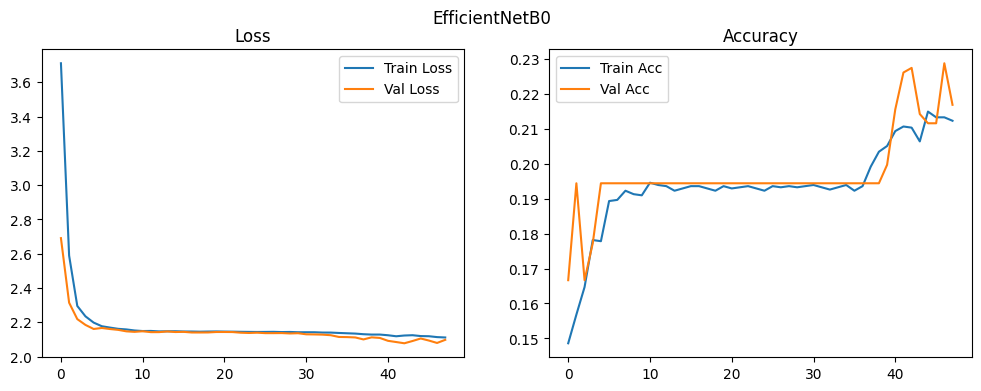

Epoch 1/50
609/609 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step - accuracy: 0.4238 - loss: 3.1765

609/609 ━━━━━━━━━━━━━━━━━━━━ 198s 323ms/step - accuracy: 0.4239 - loss: 3.1756 - val_accuracy: 0.5344 - val_loss: 2.0507
Epoch 2/50
609/609 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step - accuracy: 0.5917 - loss: 1.8195

609/609 ━━━━━━━━━━━━━━━━━━━━ 196s 323ms/step - accuracy: 0.5917 - loss: 1.8194 - val_accuracy: 0.5622 - val_loss: 1.7891
Epoch 3/50
609/609 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step - accuracy: 0.6077 - loss: 1.5352

609/609 ━━━━━━━━━━━━━━━━━━━━ 197s 324ms/step - accuracy: 0.6078 - loss: 1.5351 - val_accuracy: 0.5608 - val_loss: 1.6312
Epoch 4/50
609/609 ━━━━━━━━━━━━━━━━━━━━ 197s 324ms/step - accuracy: 0.6365 - loss: 1.3878 - val_accuracy: 0.5489 - val_loss: 1.7147
Epoch 5/50
609/609 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step - accuracy: 0.6468 - loss: 1.3733

609/609 ━━━━━━━━━━━━━━━━━━━━ 197s 323ms/step - accuracy: 0.6468 - loss: 1.3733 - val_accuracy: 0.6019 - val_loss: 1.5614
Epoch 6/50
609/609 ━━━━━━━━━━━━━━━━━━━━ 197s 324ms/step - accuracy: 0.6412 - loss: 1.3346 - val_accuracy: 0.5503 - val_loss: 1.7212
Epoch 7/50
609/609 ━━━━━━━━━━━━━━━━━━━━ 197s 324ms/step - accuracy: 0.6542 - loss: 1.3194 - val_accuracy: 0.5384 - val_loss: 1.6918
Epoch 8/50
609/609 ━━━━━━━━━━━━━━━━━━━━ 198s 326ms/step - accuracy: 0.6527 - loss: 1.3188 - val_accuracy: 0.5701 - val_loss: 1.6151
Epoch 9/50
609/609 ━━━━━━━━━━━━━━━━━━━━ 197s 324ms/step - accuracy: 0.6066 - loss: 1.3692 - val_accuracy: 0.5847 - val_loss: 1.5728
Epoch 10/50
609/609 ━━━━━━━━━━━━━━━━━━━━ 196s 322ms/step - accuracy: 0.6468 - loss: 1.3025 - val_accuracy: 0.5780 - val_loss: 1.6547


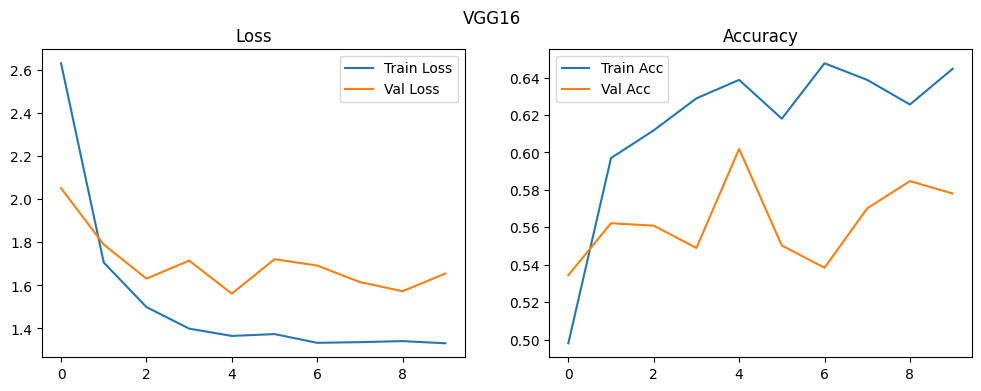

In [56]:
train_model(resnet50_model, "ResNet50")
train_model(resnet101_model, "ResNet101")
train_model(EfficientNetB0, "EfficientNetB0")
train_model(vgg16_model, "VGG16")


In [ ]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    "Processed/test",
    target_size=(224, 224),
    batch_size=1,
    class_mode='categorical',
    shuffle=False
)

def evaluate_model(model, generator, name):
    generator.reset()
    y_true = generator.classes
    y_pred_probs = model.predict(generator, verbose=1)
    y_pred = np.argmax(y_pred_probs, axis=1)
    y_true_onehot = np.eye(len(generator.class_indices))[y_true]

    print(f"\n📊 Evaluation for {name}")
    print("-" * 50)
    print(classification_report(y_true, y_pred, target_names=generator.class_indices.keys()))
    print("Macro Precision:", precision_score(y_true, y_pred, average='macro'))
    print("Macro Recall:", recall_score(y_true, y_pred, average='macro'))
    print("Macro F1-score:", f1_score(y_true, y_pred, average='macro'))
    print("Macro AUC:", roc_auc_score(y_true_onehot, y_pred_probs, average='macro', multi_class='ovr'))

Found 954 images belonging to 9 classes.


In [58]:
evaluate_model(resnet50_model, train_generator, "ResNet50 - Train Set")
evaluate_model(resnet50_model, val_generator, "ResNet50 - Validation Set")
evaluate_model(resnet50_model, test_generator, "ResNet50 - Test Set")

609/609 ━━━━━━━━━━━━━━━━━━━━ 89s 144ms/step

📊 Evaluation for ResNet50 - Train Set
--------------------------------------------------
                       precision    recall  f1-score   support

          1-Cardboard       0.11      0.05      0.07       295
      2-Food Organics       0.10      0.10      0.10       263
              3-Glass       0.08      0.09      0.09       269
              4-Metal       0.17      0.25      0.20       506
5-Miscellaneous Trash       0.11      0.07      0.09       317
              6-Paper       0.11      0.11      0.11       320
            7-Plastic       0.18      0.17      0.18       589
      8-Textile Trash       0.10      0.05      0.07       204
         9-Vegetation       0.08      0.11      0.09       279

             accuracy                           0.13      3042
            macro avg       0.12      0.11      0.11      3042
         weighted avg       0.13      0.13      0.12      3042

Macro Precision: 0.11546934033591628
Macro R

C:\Users\wuxul\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


954/954 ━━━━━━━━━━━━━━━━━━━━ 37s 39ms/step

📊 Evaluation for ResNet50 - Test Set
--------------------------------------------------
                       precision    recall  f1-score   support

          1-Cardboard       0.61      0.20      0.31        93
      2-Food Organics       0.39      0.13      0.20        83
              3-Glass       0.27      0.15      0.20        84
              4-Metal       0.45      0.78      0.57       158
5-Miscellaneous Trash       0.24      0.17      0.20        99
              6-Paper       0.33      0.48      0.39       100
            7-Plastic       0.55      0.39      0.45       185
      8-Textile Trash       0.38      0.08      0.13        64
         9-Vegetation       0.38      0.90      0.54        88

             accuracy                           0.41       954
            macro avg       0.40      0.37      0.33       954
         weighted avg       0.42      0.41      0.37       954

Macro Precision: 0.39980580315329645
Macro Rec

In [59]:
evaluate_model(resnet101_model, train_generator, "ResNet101 - Train Set")
evaluate_model(resnet101_model, val_generator, "ResNet101 - Validation Set")
evaluate_model(resnet101_model, test_generator, "ResNet101 - Test Set")

609/609 ━━━━━━━━━━━━━━━━━━━━ 147s 238ms/step

📊 Evaluation for ResNet101 - Train Set
--------------------------------------------------
                       precision    recall  f1-score   support

          1-Cardboard       0.10      0.04      0.06       295
      2-Food Organics       0.07      0.06      0.07       263
              3-Glass       0.12      0.09      0.10       269
              4-Metal       0.13      0.14      0.14       506
5-Miscellaneous Trash       0.10      0.09      0.10       317
              6-Paper       0.07      0.07      0.07       320
            7-Plastic       0.18      0.33      0.23       589
      8-Textile Trash       0.18      0.01      0.02       204
         9-Vegetation       0.07      0.09      0.08       279

             accuracy                           0.13      3042
            macro avg       0.12      0.10      0.10      3042
         weighted avg       0.12      0.13      0.11      3042

Macro Precision: 0.11579721227683987
Macro

C:\Users\wuxul\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\wuxul\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\wuxul\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classificati

954/954 ━━━━━━━━━━━━━━━━━━━━ 66s 69ms/step

📊 Evaluation for ResNet101 - Test Set
--------------------------------------------------
                       precision    recall  f1-score   support

          1-Cardboard       0.53      0.11      0.18        93
      2-Food Organics       0.40      0.17      0.24        83
              3-Glass       0.42      0.10      0.16        84
              4-Metal       0.46      0.65      0.54       158
5-Miscellaneous Trash       0.11      0.08      0.09        99
              6-Paper       0.35      0.36      0.36       100
            7-Plastic       0.42      0.64      0.51       185
      8-Textile Trash       0.00      0.00      0.00        64
         9-Vegetation       0.39      0.91      0.55        88

             accuracy                           0.40       954
            macro avg       0.34      0.34      0.29       954
         weighted avg       0.37      0.40      0.34       954

Macro Precision: 0.34332932724197496
Macro Re

C:\Users\wuxul\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\wuxul\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\wuxul\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classificati

In [60]:
evaluate_model(EfficientNetB0, train_generator, "EfficientNetB0 - Train Set")
evaluate_model(EfficientNetB0, val_generator, "EfficientNetB0 - Validation Set")
evaluate_model(EfficientNetB0, test_generator, "EfficientNetB0 - Test Set")

609/609 ━━━━━━━━━━━━━━━━━━━━ 52s 83ms/step

📊 Evaluation for EfficientNetB0 - Train Set
--------------------------------------------------
                       precision    recall  f1-score   support

          1-Cardboard       0.00      0.00      0.00       295
      2-Food Organics       0.00      0.00      0.00       263
              3-Glass       0.00      0.00      0.00       269
              4-Metal       0.00      0.00      0.00       506
5-Miscellaneous Trash       0.00      0.00      0.00       317
              6-Paper       0.00      0.00      0.00       320
            7-Plastic       0.19      0.99      0.32       589
      8-Textile Trash       0.00      0.00      0.00       204
         9-Vegetation       0.22      0.02      0.04       279

             accuracy                           0.19      3042
            macro avg       0.05      0.11      0.04      3042
         weighted avg       0.06      0.19      0.07      3042

Macro Precision: 0.04613967201031878
Ma

C:\Users\wuxul\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\wuxul\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\wuxul\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classificati

152/152 ━━━━━━━━━━━━━━━━━━━━ 12s 80ms/step

📊 Evaluation for EfficientNetB0 - Validation Set
--------------------------------------------------
                       precision    recall  f1-score   support

          1-Cardboard       0.00      0.00      0.00        73
      2-Food Organics       0.00      0.00      0.00        65
              3-Glass       0.00      0.00      0.00        67
              4-Metal       0.00      0.00      0.00       126
5-Miscellaneous Trash       0.00      0.00      0.00        79
              6-Paper       0.00      0.00      0.00        80
            7-Plastic       0.20      0.97      0.33       147
      8-Textile Trash       0.00      0.00      0.00        50
         9-Vegetation       0.04      0.01      0.02        69

             accuracy                           0.19       756
            macro avg       0.03      0.11      0.04       756
         weighted avg       0.04      0.19      0.07       756

Macro Precision: 0.025793650793650

C:\Users\wuxul\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\wuxul\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\wuxul\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classificati

954/954 ━━━━━━━━━━━━━━━━━━━━ 18s 19ms/step

📊 Evaluation for EfficientNetB0 - Test Set
--------------------------------------------------
                       precision    recall  f1-score   support

          1-Cardboard       0.00      0.00      0.00        93
      2-Food Organics       0.00      0.00      0.00        83
              3-Glass       0.00      0.00      0.00        84
              4-Metal       0.00      0.00      0.00       158
5-Miscellaneous Trash       0.00      0.00      0.00        99
              6-Paper       0.00      0.00      0.00       100
            7-Plastic       0.20      1.00      0.34       185
      8-Textile Trash       0.00      0.00      0.00        64
         9-Vegetation       0.16      0.08      0.11        88

             accuracy                           0.20       954
            macro avg       0.04      0.12      0.05       954
         weighted avg       0.05      0.20      0.08       954

Macro Precision: 0.039897323065639895
Ma

C:\Users\wuxul\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\wuxul\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\wuxul\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classificati

In [61]:
evaluate_model(vgg16_model, train_generator, "vgg16_model - Train Set")
evaluate_model(vgg16_model, val_generator, "vgg16_model - Validation Set")
evaluate_model(vgg16_model, test_generator, "vgg16_model - Test Set")

609/609 ━━━━━━━━━━━━━━━━━━━━ 158s 259ms/step

📊 Evaluation for vgg16_model - Train Set
--------------------------------------------------
                       precision    recall  f1-score   support

          1-Cardboard       0.12      0.11      0.11       295
      2-Food Organics       0.09      0.08      0.08       263
              3-Glass       0.09      0.08      0.09       269
              4-Metal       0.17      0.19      0.18       506
5-Miscellaneous Trash       0.12      0.12      0.12       317
              6-Paper       0.14      0.13      0.13       320
            7-Plastic       0.20      0.21      0.21       589
      8-Textile Trash       0.09      0.08      0.08       204
         9-Vegetation       0.10      0.11      0.11       279

             accuracy                           0.14      3042
            macro avg       0.12      0.12      0.12      3042
         weighted avg       0.14      0.14      0.14      3042

Macro Precision: 0.12433473415129999
Mac